## **Import**

In [2]:
# Imports
import os
import sys
import numpy as np
import pandas as pd
import cv2
import time
import json
from IPython.core.display import HTML
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from keras.models import Model, Sequential
from keras import layers
from keras import activations
from keras import optimizers
from keras import losses
from keras import initializers
from keras import regularizers
from keras.utils import to_categorical, plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
# Import pretrained models
from keras.applications import ResNet50V2,VGG16, InceptionV3, MobileNetV2, DenseNet121

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import xml.etree.ElementTree as ET # for parsing XML
from PIL import Image # to read images
# import tensorflow_datasets as tfds
# import tensorflow_addons as tfa

In [3]:
# https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)

tensorflow version 2.10.1
keras version 2.10.0


## **Dog DataSet**

In [7]:
!rm -rf DatasetStore

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
# import requests
# import tarfile
# dataset_path = "DatasetStore"
# 
# # Download and extract dataset
# if not os.path.exists(dataset_path):
#   os.mkdir(dataset_path)
#   packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
#   packet_file = os.path.basename(packet_url)
#   packet_file = os.path.join(dataset_path, packet_file)
#   with requests.get(packet_url, stream=True) as r:
#       r.raise_for_status()
#       with open(packet_file, 'wb') as f:
#           for chunk in r.iter_content(chunk_size=8192):
#               f.write(chunk)
# 
#   with tarfile.open(packet_file) as tfile:
#     tfile.extractall(dataset_path)
# 
#   packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"
#   packet_file = os.path.basename(packet_url)
#   packet_file = os.path.join(dataset_path, packet_file)
#   with requests.get(packet_url, stream=True) as r:
#       r.raise_for_status()
#       with open(packet_file, 'wb') as f:
#           for chunk in r.iter_content(chunk_size=8192):
#               f.write(chunk)
# 
#   with tarfile.open(packet_file) as tfile:
#     tfile.extractall(dataset_path)

**Load data**

In [5]:
import pickle
breed_list = os.listdir('../Dog_Breed_Dataset/Dogs/') # list of all breeds for further demo
breed_list.sort()

# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(breed_list))
index2label = dict((index, name) for index, name in enumerate(breed_list))
with open('label2index_tsinghua.pickle', 'wb') as f:
    pickle.dump(label2index, f)

images = []
annotations =[]
for breed in breed_list:
  image_files = os.listdir('../Dog_Breed_Dataset/Dogs/' + breed)
  image_files.sort()
  images.extend([os.path.join('../Dog_Breed_Dataset/Dogs/',breed,f) for f in image_files])
  annotations.extend([os.path.join('../Dog_Breed_Dataset/',breed,f.replace(".jpg","")).replace("\\","/") for f in image_files])

for idx, ann in enumerate(annotations):
    annotations[idx] = ann.split("/")[2] # add dog breed name

# Prepare train test validate datasets
Xs = np.asarray(images)
Ys = np.asarray(annotations)


# print('Xs shape',Xs.shape)
# print(Xs[:5])
# print('Ys shape',Ys.shape)
# print(Ys[:5])

# Split into train_validate + test data
train_validate_x,test_x, train_validate_y, test_y = train_test_split(Xs,Ys,test_size=0.1)

# print("train_validate_x shape:",train_validate_x.shape)
# print('train_validate_x[:5]:',train_validate_x[:5])
# print("train_validate_y shape:",train_validate_y.shape)
# print('train_validate_y[:5]:',train_validate_y[:5])
# 
# print("test_x shape:",test_x.shape)
# print('test_x[:5]:',test_x[:5])
# print("test_y shape:",test_y.shape)
# print('test_y[:5]:',test_y[:5])

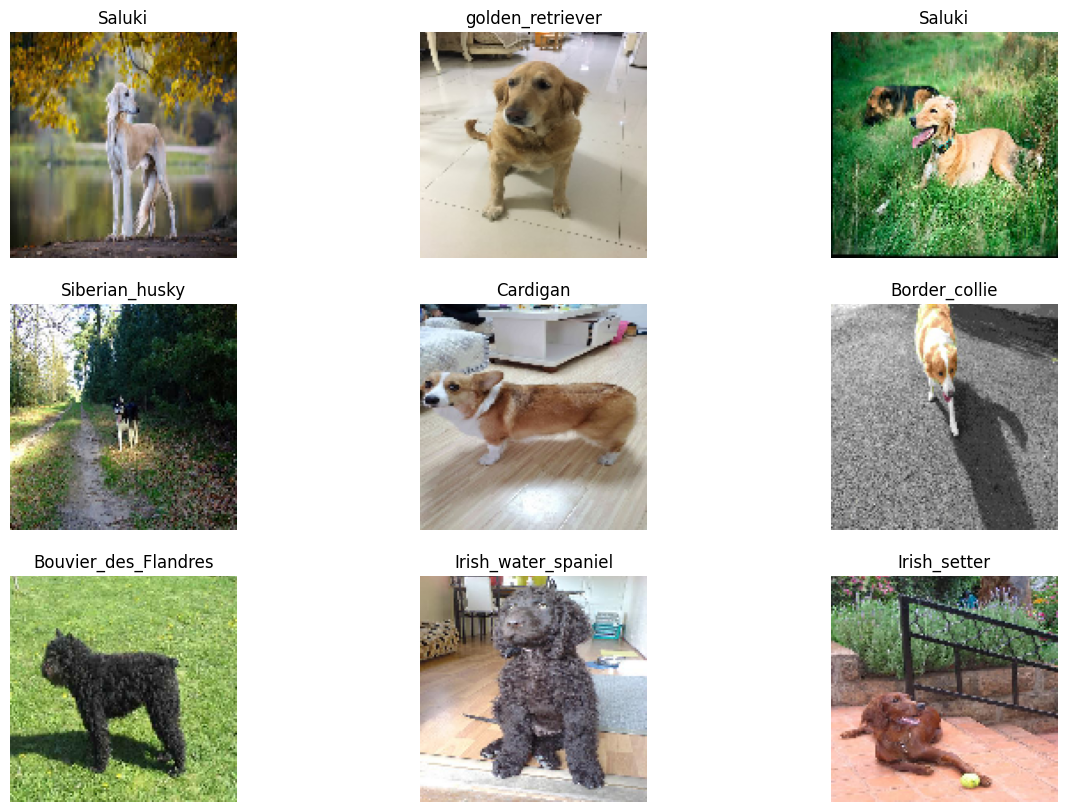

In [6]:
# View a few train images
fig = plt.figure(figsize=(15,10))

for idx in range(9):
    sample_input = tf.keras.preprocessing.image.load_img(
        train_validate_x[idx].replace("\\","/"), target_size=(128, 128)
    )
    name = train_validate_x[idx].replace("\\","/").split("/")[3]
    breed = name
    axs = fig.add_subplot(3,3,idx+1)
    axs.set_title(breed)
    plt.imshow(sample_input)
    plt.axis('off')
# 
# plt.show()



## **Build Data Generator**

In [8]:
validation_percent = 0.2
image_width = 128
image_height = 128
num_channels = 3
num_classes = len(breed_list)

epochs = 50
train_batch_size = 32
validation_batch_size = 32
test_batch_size = 32
train_shuffle_size = train_batch_size * 3
validation_shuffle_size = validation_batch_size * 3
# Split data into train / validation
train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size=validation_percent)

#  Converts to binary class matrix (One-hot-encoded)

train_processed_y = np.asarray([label2index[label] for label in train_y])
validate_processed_y = np.asarray([label2index[label] for label in validate_y])
test_processed_y = np.asarray([label2index[label] for label in test_y])
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')
test_processed_y = to_categorical(test_processed_y, num_classes=num_classes, dtype='float32')

train_data_count = train_x.shape[0]
steps_per_epoch = int(train_data_count // train_batch_size)
validation_data_count = validate_x.shape[0]
validation_steps = int(validation_data_count // validation_batch_size)

# Prepare the data
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=num_channels)
    image = tf.image.resize(image,[image_height,image_width])
    return image, label

# Normalize pixels
def normalize(image, label):
    image = image/255
    return image, label

def build_data_generators(train_data_process_list=[load_image,normalize],validate_data_process_list=[load_image,normalize],test_data_process_list=[load_image,normalize]):

    # Create TF Dataset
    train_data = tf.data.Dataset.from_tensor_slices((train_x.tolist(), train_processed_y.tolist()))
    validation_data = tf.data.Dataset.from_tensor_slices((validate_x.tolist(), validate_processed_y.tolist()))
    test_data = tf.data.Dataset.from_tensor_slices((test_x.tolist(), test_processed_y.tolist()))


    # Train data
    # Shuffle
    train_data = train_data.shuffle(train_data_count)
    # Apply all data processing logic
    for process in train_data_process_list:
        train_data = train_data.map(process, num_parallel_calls=AUTOTUNE)

    train_data = train_data.repeat(epochs).batch(train_batch_size)

    # Validation data
    # Shuffle
    validation_data = validation_data.shuffle(validation_data_count)
    # Apply all data processing logic
    for process in validate_data_process_list:
        validation_data = validation_data.map(process, num_parallel_calls=AUTOTUNE)

    validation_data = validation_data.repeat(epochs).batch(validation_batch_size)

    # Test data
    # Apply all data processing logic
    for process in test_data_process_list:
        test_data = test_data.map(process, num_parallel_calls=AUTOTUNE)
    test_data = test_data.repeat(1).batch(test_batch_size)

    return train_data, validation_data, test_data

train_data, validation_data, test_data = build_data_generators()
print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

train_data <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 132), dtype=tf.float32, name=None))>
validation_data <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 132), dtype=tf.float32, name=None))>
test_data <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 132), dtype=tf.float32, name=None))>


## **Utility Function**

In [9]:
import decimal

class JsonEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, decimal.Decimal):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(JsonEncoder, self).default(obj)

def get_model_metrics():
    with open("./SavedModels/tsinghuamodel_metrics.json") as json_file:
        model_metrics = json.load(json_file)

    return model_metrics

def save_model_metrics(model_name="model_1",metrics={}):
    if os.path.exists("./SavedModels/tsinghuamodel_metrics.json"):
        with open("./SavedModels/tsinghuamodel_metrics.json") as json_file:
            model_metrics = json.load(json_file)
    else:
        model_metrics = {}

    model_metrics[model_name] = metrics

    # Save the json
    with open("./SavedModels/tsinghuamodel_metrics.json", 'w') as json_file:
        json_file.write(json.dumps(model_metrics, cls=JsonEncoder))

def save_model(path="./SavedModels",model_name="model01"):
    filename = "./SavedModels/"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    # Save the enitire model (structure + weights)
    model.save(os.path.join(path,model_name+".hdf5"))

    # Save only the weights
    model.save_weights(os.path.join(path,model_name+".h5"))

    # Save the structure only
    model_json = model.to_json()
    with open(os.path.join(path,model_name+".json"), "w") as json_file:
        json_file.write(model_json)

def get_model_size(path="./SavedModels",model_name="model01"):
    model_size = os.stat(os.path.join(path,model_name+".hdf5")).st_size
    return model_size

def evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer,momentum = None, save=True):

    # Get the model train history
    model_train_history = training_results.history
    # Get the number of epochs the training was run for
    num_epochs = len(model_train_history["loss"])

    # Plot training results
    fig = plt.figure(figsize=(15,5))
    axs = fig.add_subplot(1,2,1)
    axs.set_title('Loss')
    # Plot all metrics
    for metric in ["loss","val_loss"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()

    axs = fig.add_subplot(1,2,2)
    axs.set_title('Accuracy')
    # Plot all metrics
    for metric in ["accuracy","val_accuracy"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()

    plt.show()

    # Evaluate on test data
    evaluation_results = model.evaluate(test_data)
    print('Evaluation results: [loss, accuracy]', evaluation_results)

    if save:
        # Save model
        save_model(model_name=model.name)
        model_size = get_model_size(model_name=model.name)

        # Save model history
        with open(os.path.join("./SavedModels","tsinghua"+model.name+"_train_history.json"), "w") as json_file:
            json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

        trainable_parameters = model.count_params()

        # Save model metrics
        metrics ={
            "trainable_parameters":trainable_parameters,
            "execution_time":execution_time,
            "loss":evaluation_results[0],
            "accuracy":evaluation_results[1],
            "model_size":model_size,
            "learning_rate":learning_rate,
            "batch_size":batch_size,
            'momentum': momentum,
            "epochs":epochs,
            "optimizer":type(optimizer).__name__
        }
        save_model_metrics(model_name=model.name,metrics=metrics)

Compare all models

In [60]:
# Compare model metrics
view_metrics = pd.read_json("./SavedModels/tsinghuamodel_metrics.json")
view_metrics = view_metrics.T
# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
#view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.0f} MB'.format)
print('Number of models:',view_metrics.shape[0])

FileNotFoundError: File ./SavedModels/tsinghuamodel_metrics.json does not exist

## **VGG16**
Use VGG16 as the base and fine tune the last conv2d block for our problem

### Build model

In [10]:
# vgg16 with fine tuning the last conv2d base
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(image_height,image_width,3))

def view_layers(model):
    layers = model.layers
    layers_list = []

    for idx, layer in enumerate(layers):
        layers_list.append({
            'layer': type(layer).__name__,
            'trainable':layer.trainable
        })

    df = pd.DataFrame(layers_list)

    return df

layers_df = view_layers(vgg16)


### Training params

In [11]:
############################
# Training Params
############################
learning_rate = 0.001
batch_size = 32
epochs = 50
############################


# Set all layers as trainable false execpt last conv block
for layer in vgg16.layers[:-4]:
    layer.trainable = False

# Input
model_input = vgg16.layers[0].input

# Final pool layer
hidden = vgg16.layers[-1]
print("Pool Layer",hidden)

# Flatten
hidden = layers.Flatten()(hidden.output)

#  Hidden Layer, Classification Block
hidden = layers.Dense(units=1024, activation='relu')(hidden)
hidden = layers.Dense(units=1024, activation='relu')(hidden)

# Output Layer
output = layers.Dense(units=num_classes, activation='softmax')(hidden)

# Build model
model = Model(model_input, output, name='VGG16')

# Optimizer
optimizer = optimizers.SGD(learning_rate=learning_rate)

# Loss
loss = losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

#print(model.summary())
layers_df = view_layers(model)

Pool Layer <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002138F692590>


### Train model

In [ ]:
# Train model

# Early Stopping
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10)

# Model Checkpoint
checkpoint_filepath = './Checkpoints/checkpoint_VGG16'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)


start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        callbacks=[earlystopping,model_checkpoint_callback],
        epochs=epochs,
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)


Epoch 1/50
2047/2047 [==============================] - ETA: 0s - loss: 3.7810 - accuracy: 0.1776
Epoch 1: val_accuracy improved from -inf to 0.27911, saving model to ./Checkpoints\checkpoint_VGG16
2047/2047 [==============================] - 97s 45ms/step - loss: 3.7810 - accuracy: 0.1776 - val_loss: 3.1215 - val_accuracy: 0.2791
Epoch 2/50
2046/2047 [============================>.] - ETA: 0s - loss: 2.7484 - accuracy: 0.3226
Epoch 2: val_accuracy improved from 0.27911 to 0.35757, saving model to ./Checkpoints\checkpoint_VGG16
2047/2047 [==============================] - 87s 43ms/step - loss: 2.7483 - accuracy: 0.3226 - val_loss: 2.5498 - val_accuracy: 0.3576
Epoch 3/50
 472/2047 [=====>........................] - ETA: 55s - loss: 2.3715 - accuracy: 0.3928

### Evaluate and Save

In [2]:
# Evaluate and Save model
evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer)

NameError: name 'evaluate_save_model' is not defined

## **ResNet50V2 with Adam optimizer**

In [18]:
resnet50_v2 = ResNet50V2(
    include_top=False,
    input_shape=(128, 128, 3)
)

### Build model

In [22]:
# Build model for Resnet
def build_resnet_model(model_name = 'ResNet50V2',print_summary=True):
  # Set all layers as hidden
  for layer in resnet50_v2.layers:
      layer.trainable = False

  # Input
  model_input = resnet50_v2.layers[0].input

  # Extract final pool layer
  hidden = resnet50_v2.layers[-1]

  # Flatten
  hidden = layers.Flatten()(hidden.output)

  # Output Layer
  output = layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(model_input, output, name=model_name)

  # Print the model architecture
  if print_summary:
    print(model.summary())

  return model

### Training params

In [23]:
############################
# Training Params
############################
batch_size = 32
epochs = 50
############################

# Early Stopping
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10)

# Model Checkpoint
checkpoint_filepath = './Checkpoints/checkpoint_ResNet50V2'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

# Build the model
model = build_resnet_model(print_summary=False)

# Optimier
optimizer = optimizers.Adam()

# Loss
loss = losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])




In [3]:
from pathlib import Path
import imghdr

from pathlib import Path
import imghdr

img_link=list(Path("../Dog_Breed_Dataset/Dogs/").glob(r'**/*.jpg'))

count_num=0
for lnk in img_link:
    binary_img=open(lnk,'rb')
    find_img=tf.compat.as_bytes('JFIF') in binary_img.peek(10)#The JFIF is a JPEG File Interchange Format (JFIF). It is a standard which we gauge if an image is corrupt or substandard
    if not find_img:
        count_num+=1
        os.remove(str(lnk))
print('Total %d pcs image delete from Dataset' % count_num)
#this should help you delete the bad encoded

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: '..\\Dog_Breed_Dataset\\Dogs\\Australian_terrier\\n109746.jpg'

### Train model

In [24]:
# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[earlystopping,model_checkpoint_callback],
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)



Epoch 1/50
 379/2047 [====>.........................] - ETA: 52s - loss: 23.4291 - accuracy: 0.3334

InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]]
	 [[categorical_crossentropy/softmax_cross_entropy_with_logits/Shape_2/_6]]
  (1) INVALID_ARGUMENT:  Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_13243]

### Evaluate and Save

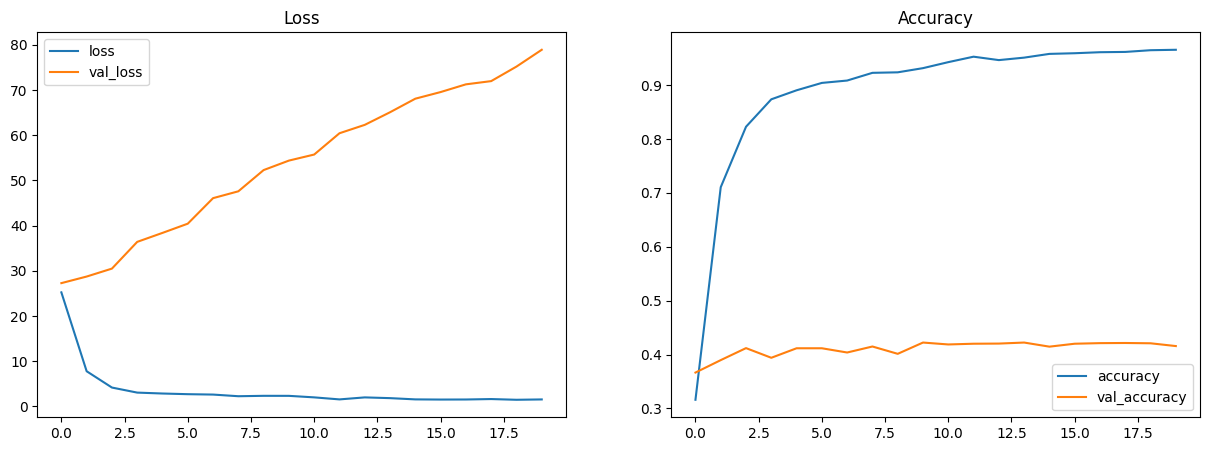

65/65 [==============================] - 2s 29ms/step - loss: 77.4970 - accuracy: 0.4281
Evaluation results: [loss, accuracy] [77.49699401855469, 0.4280855059623718]


In [117]:
# Evaluate and Save model
learning_rate = 0.001
evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer)

## Add data augmentation to ResNet50V2

In [118]:
# Create data augmentation processors

# https://www.tensorflow.org/api_docs/python/tf/image/adjust_brightness
def adjust_brightness(image, label):
    return tf.image.adjust_brightness(image, 0.01), label

# https://www.tensorflow.org/api_docs/python/tf/image/adjust_contrast
def adjust_contrast(image, label):
    return tf.image.adjust_contrast(image, 1.2), label

# Apply data processing + data augmentation steps
data_process_list=[load_image, normalize, adjust_brightness, adjust_contrast]

# Build data generators for train, validate, test
train_data, validation_data, test_data = build_data_generators(train_data_process_list=data_process_list)
print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

train_data <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>
validation_data <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>
test_data <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>


### Build model

In [119]:
############################
# Training Params
############################
batch_size = 32
epochs = 50
############################

# Early Stopping
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10);

# Model Checkpoint
checkpoint_filepath = './Checkpoints/checkpoint_ResNet50V2DataAug'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

# Build the model
model = build_resnet_model(model_name='ResNet50V2_DataAug')

# Loads the weights
checkpoint_path = './Checkpoints/checkpoint_ResNet50V2'
model.load_weights(checkpoint_path)

# Optimier
optimizer = optimizers.Adam()

# Loss
loss = losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])





Model: "ResNet50V2_DataAug"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][

### Train model

In [120]:
# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[earlystopping,model_checkpoint_callback],
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)



Epoch 1/50
463/463 [==============================] - ETA: 0s - loss: 2.4645 - accuracy: 0.9295
Epoch 1: val_accuracy improved from -inf to 0.42636, saving model to ./Checkpoints\checkpoint_ResNet50V2DataAug
463/463 [==============================] - 22s 44ms/step - loss: 2.4645 - accuracy: 0.9295 - val_loss: 57.0634 - val_accuracy: 0.4264
Epoch 2/50
463/463 [==============================] - ETA: 0s - loss: 2.1075 - accuracy: 0.9411
Epoch 2: val_accuracy did not improve from 0.42636
463/463 [==============================] - 20s 42ms/step - loss: 2.1075 - accuracy: 0.9411 - val_loss: 60.5105 - val_accuracy: 0.4158
Epoch 3/50
463/463 [==============================] - ETA: 0s - loss: 1.8723 - accuracy: 0.9456
Epoch 3: val_accuracy did not improve from 0.42636
463/463 [==============================] - 20s 42ms/step - loss: 1.8723 - accuracy: 0.9456 - val_loss: 63.9540 - val_accuracy: 0.4133
Epoch 4/50
463/463 [==============================] - ETA: 0s - loss: 1.8353 - accuracy: 0.9514


### Evaluate and Save

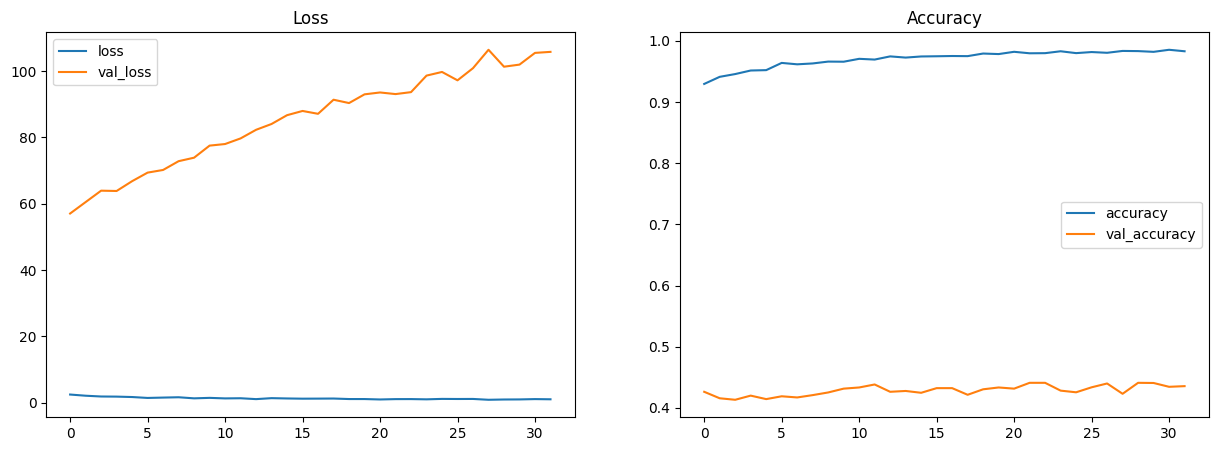

65/65 [==============================] - 2s 29ms/step - loss: 106.1695 - accuracy: 0.4359
Evaluation results: [loss, accuracy] [106.1695327758789, 0.4358600676059723]


In [121]:
# Evaluate and Save model
evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer)

## Display predictions

65/65 [==============================] - 2s 27ms/step


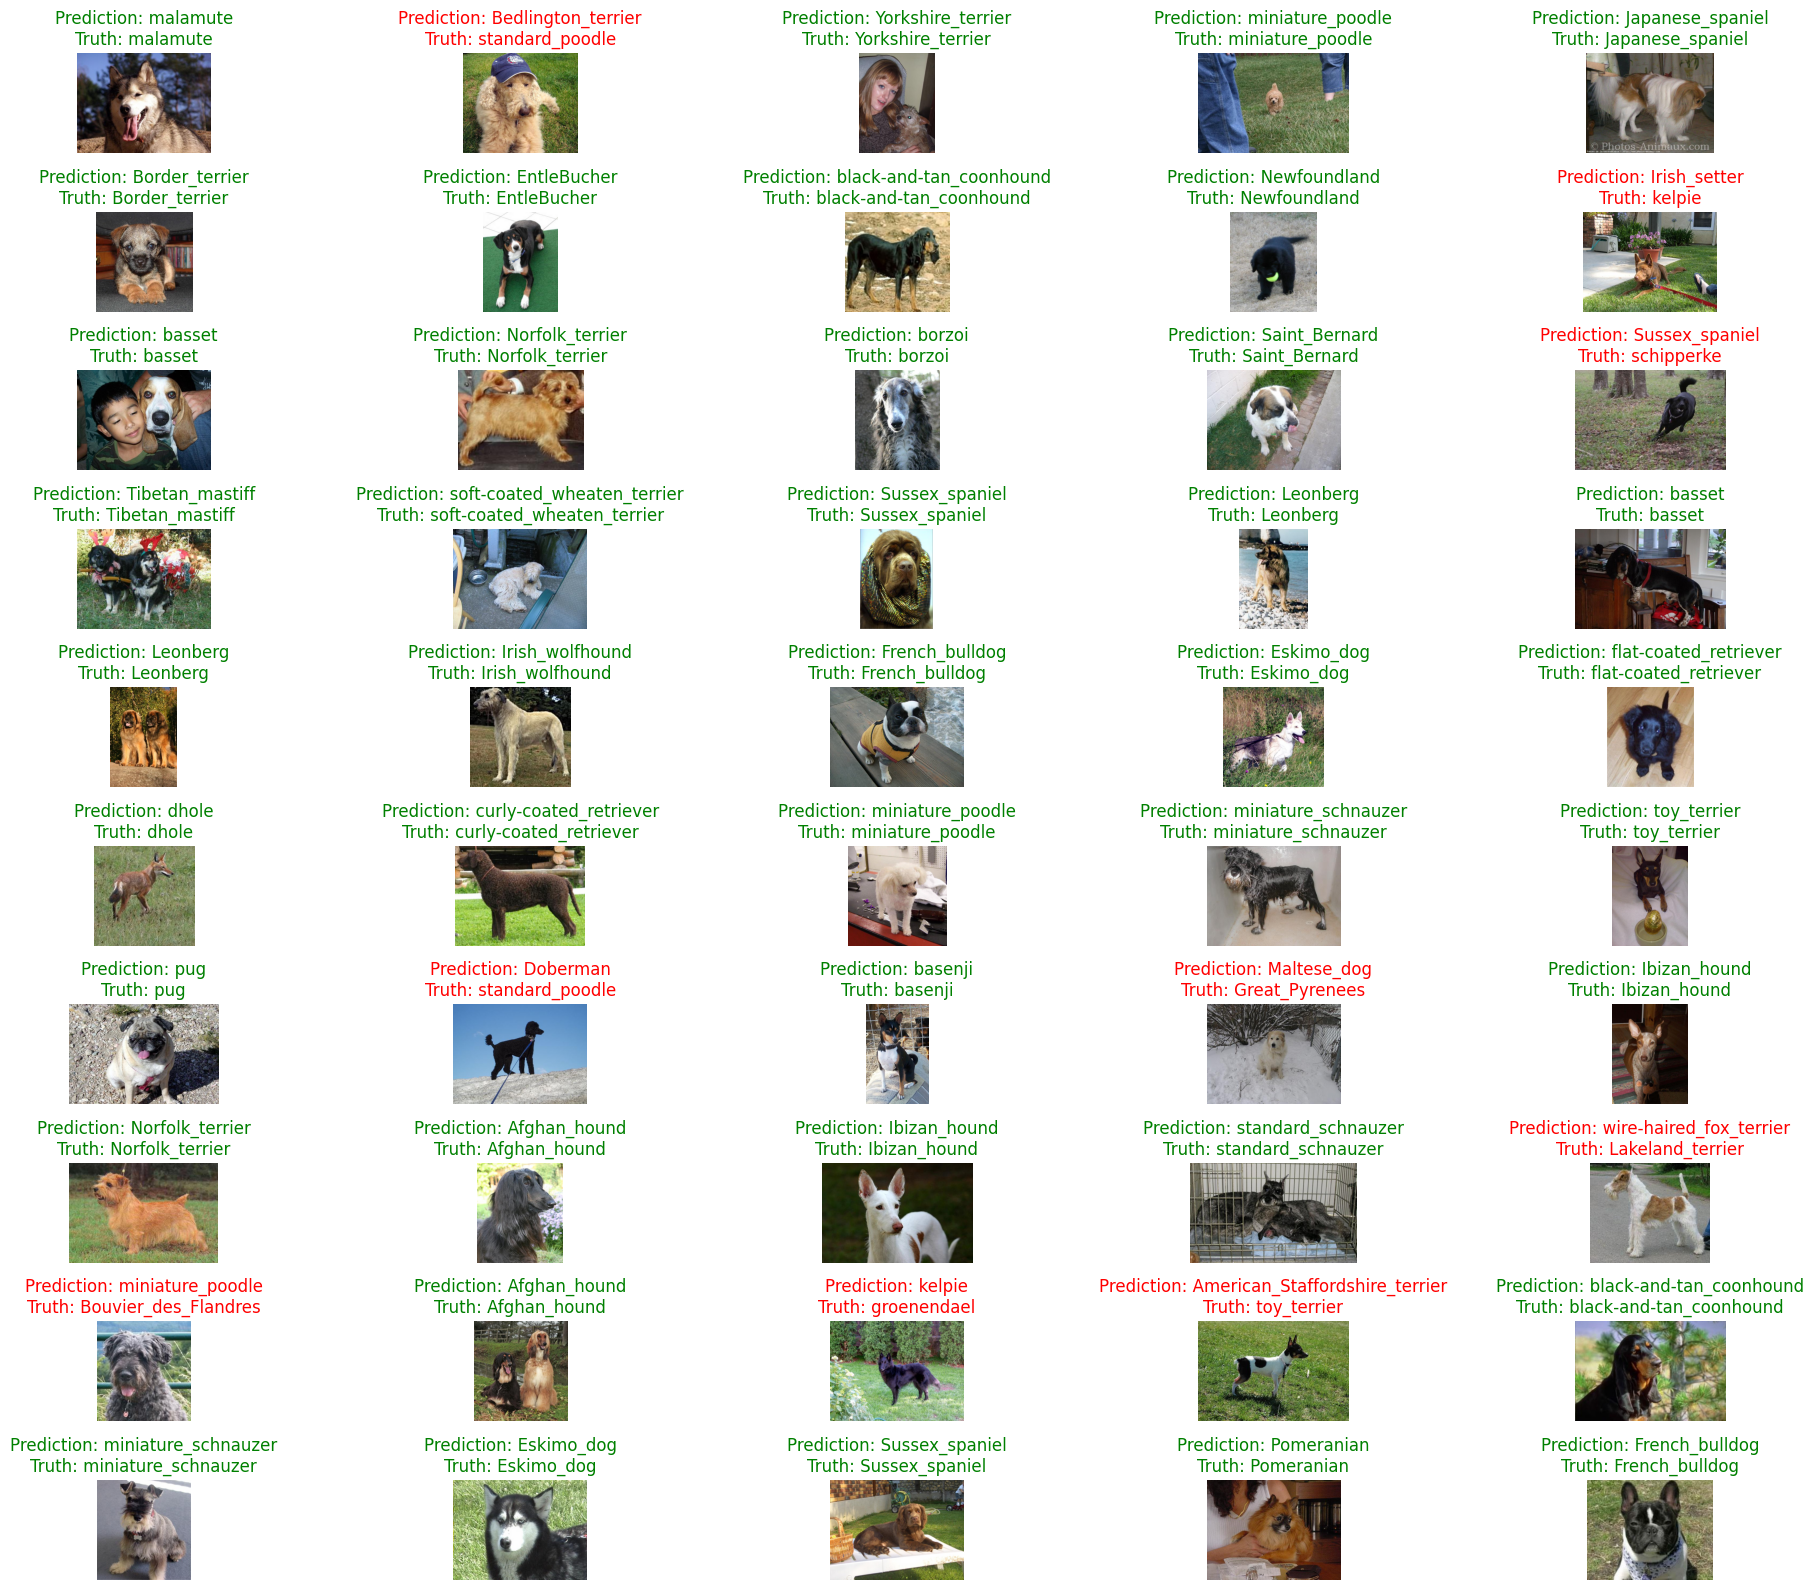

# of true predictions:  41
# of false predictions:  9


In [126]:
# load best model with best weights
prediction_model = tf.keras.models.load_model('./SavedModels/ResNet50V2_DataAug.hdf5', compile=False)
prediction_model.compile()
checkpoint_path = './Checkpoints/checkpoint_ResNet50V2DataAug'
prediction_model.load_weights(checkpoint_path)

# make predictions
test_predictions = prediction_model.predict(test_data)

# Load Test images
test_x_display = []
for path in test_x:
    path = path.replace("/", "\\")
    # read image
    image = cv2.imread(path)
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Train x
    test_x_display.append(image)
# Convert to numpy array
test_x_display = np.asarray(test_x_display, dtype=object)

# add true and predicted breed for each dog image
# mark it green if prediction is true, otherwise red
# count the total number of true predictions for the first 100 images
true_predict = 0
false_predict = 0
fig = plt.figure(figsize=(20,16))
for i,file in enumerate(test_x_display[:50]):
    axs = fig.add_subplot(10,5,i+1)
    axs.set_aspect('equal')
    predicted_breed = index2label[test_predictions.argmax(axis=1)[i]][10:] # [10:] truncates leading unnecessary letters
    true_breed = test_y[i][10:]
    # color code true/false predictions
    if true_breed == predicted_breed:
      axs.set_title('Prediction: ' + predicted_breed + '\n' + 'Truth: ' + true_breed,color='green')
      true_predict += 1
    else:
      axs.set_title('Prediction: ' + predicted_breed + '\n' + 'Truth: ' + true_breed,color='red')
      false_predict += 1
    plt.imshow(test_x_display[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

print('# of true predictions: ', true_predict)
print('# of false predictions: ', false_predict)

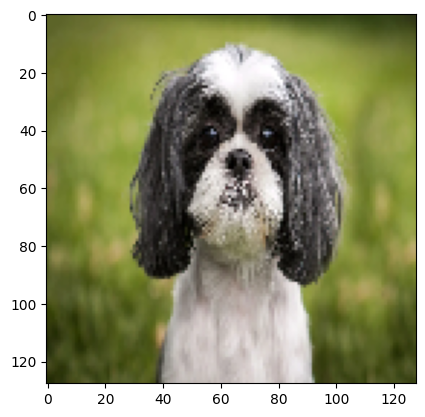

In [22]:
test_img = tf.keras.preprocessing.image.load_img(
    'C:\\Users\Felix\Downloads\Shih-tzu-dog.jpg', target_size=(128, 128)
)
test_img = tf.keras.preprocessing.image.img_to_array(test_img)
# test_img = np.expand_dims(test_img, axis=0)
test_img = test_img/255
plt.imshow(test_img)
test_img = np.asarray([test_img])

In [23]:
# predict on test_img
import pickle
# load best model with best weights
prediction_model = tf.keras.models.load_model('./SavedModels/GOOD_ResNet50V2_DataAug.hdf5', compile=False) #path to model XXX_ResNet50V2DataAug.hdf5
prediction_model.compile()
checkpoint_path = './Checkpoints/GOOD_ResNet50V2DataAug' #path to checkpoint XXX_ResNet50V2DataAug
prediction_model.load_weights(checkpoint_path)

# make predictions
test_predictions = prediction_model.predict(test_img)
with open('label2index.pickle', 'rb') as f:
    class_arr = pickle.load(f)
class_arr = {v: k for k, v in class_arr.items()}
print(class_arr)
print(class_arr[test_predictions.argmax(axis=1)[0]])



1/1 [==============================] - 0s 371ms/step
{0: 'n02085620-Chihuahua', 1: 'n02085782-Japanese_spaniel', 2: 'n02085936-Maltese_dog', 3: 'n02086079-Pekinese', 4: 'n02086240-Shih-Tzu', 5: 'n02086646-Blenheim_spaniel', 6: 'n02086910-papillon', 7: 'n02087046-toy_terrier', 8: 'n02087394-Rhodesian_ridgeback', 9: 'n02088094-Afghan_hound', 10: 'n02088238-basset', 11: 'n02088364-beagle', 12: 'n02088466-bloodhound', 13: 'n02088632-bluetick', 14: 'n02089078-black-and-tan_coonhound', 15: 'n02089867-Walker_hound', 16: 'n02089973-English_foxhound', 17: 'n02090379-redbone', 18: 'n02090622-borzoi', 19: 'n02090721-Irish_wolfhound', 20: 'n02091032-Italian_greyhound', 21: 'n02091134-whippet', 22: 'n02091244-Ibizan_hound', 23: 'n02091467-Norwegian_elkhound', 24: 'n02091635-otterhound', 25: 'n02091831-Saluki', 26: 'n02092002-Scottish_deerhound', 27: 'n02092339-Weimaraner', 28: 'n02093256-Staffordshire_bullterrier', 29: 'n02093428-American_Staffordshire_terrier', 30: 'n02093647-Bedlington_terrier', 

In [ ]:
view_metrics.sort_values(by=['accuracy'],ascending=False).head(10)

,trainable_parameters,execution_time,loss,accuracy,model_size,learning_rate,batch_size,momentum,epochs,optimizer
ResNet50V2_DataAug,"27,497,080",4.41 mins,30.9805,79.40%,142 MB,0.001,32,None,50,Adam
ResNet50V2,"27,497,080",13.14 mins,92.6662,43.68%,142 MB,0.001,32,None,50,Adam
VGG16,"24,276,920",18.02 mins,3.94702,32.46%,97 MB,0.001,32,None,50,SGD
